**AutoRec Project**

# Imports

In [1]:
%matplotlib inline

In [2]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 5.2 MB/s 


In [3]:
from google.colab import drive
import os

from tensorflow.keras.models import load_model
import tensorflow as tf
import keras_tuner as kt

from sklearn.model_selection import train_test_split

import sys
import requests
import zipfile
import copy
import shutil

import pandas as pd
import numpy as np
import random
import math

from matplotlib import pyplot as plt

In [4]:
np.random.seed(123)
random.seed(123)

In [5]:
!git clone https://github.com/aviadar/RecSys_AutoRecProject proj

Cloning into 'proj'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 176 (delta 75), reused 130 (delta 36), pack-reused 0
Receiving objects: 100% (176/176), 286.75 MiB | 37.49 MiB/s, done.
Resolving deltas: 100% (75/75), done.
Checking out files: 100% (17/17), done.


In [6]:
sys.path.insert(0,'/content/proj/src')

from utilities.Metrics import Metrics
from models.MF import MF
from models.IAutoRec import IAutoRec
from models.IAutoRecEnhanced import IAutoRecEnhanced
from models.IAutoRecEnhanced2 import IAutoRecEnhanced2

In [7]:
use_pretrained_model_mf = False
use_pretrained_model_autorec = False
use_pretrained_model_autorec_enhanced = False
use_pretrained_model_autorec_enhanced2 = False

# Netflix Prize Dataset

## Data Loading and Manupulation

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
with zipfile.ZipFile('/content/drive/MyDrive/rec_sys/datasets/netflix_prize.zip',"r") as zip_ref:
    zip_ref.extractall()

note that we are loading only part of the dataset because of RAM issues.

In [10]:
if not os.path.isfile('netflix_data.csv'):
    netflix_data = open('netflix_data.csv', mode='w')    
    row = list()
    files=['/content/combined_data_1.txt']
    #,'/content/combined_data_2.txt']#, 
#            '/content/combined_data_3.txt', '/content/combined_data_4.txt']
    for file in files:
        with open(file) as f:
            for line in f: 
                del row[:]
                line = line.strip()
                if line.endswith(':'):
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    netflix_data.write(','.join(row))
                    netflix_data.write('\n')
    netflix_data.close()

In [11]:
netflix_df = pd.read_csv('netflix_data.csv', sep=',', names=['item_id', 'user_id','rating','date'])
# netflix_df.date = pd.to_datetime(netflix_df.date)
netflix_df.drop(columns=['date'], inplace=True)
# netflix_df = netflix_df.sample(frac = 1)
netflix_df = netflix_df.sort_values(by=['user_id'])
netflix_df = netflix_df.iloc[:int(1e6)]
netflix_df.head()

,item_id,user_id,rating
881625,197,6,3
1438379,299,6,3
2547216,468,6,3
17387129,3333,6,4
1368432,295,6,4


In [12]:
netflix_df.shape

(1000000, 3)

checking for duplicates:

In [14]:
sum(netflix_df.duplicated(['item_id','user_id']))

0

changing ids into indicies:

In [15]:
user_trans_dict =  {k:v for k,v in zip(netflix_df.user_id.unique(), range(netflix_df.user_id.nunique()))}
item_trans_dict =  {k:v for k,v in zip(netflix_df.item_id.unique(), range(netflix_df.item_id.nunique()))}

def item_trans(key_value):
    return item_trans_dict[key_value]

def user_trans(key_value):
    return user_trans_dict[key_value]

netflix_df.user_id = netflix_df.user_id.apply(user_trans)
netflix_df.item_id = netflix_df.item_id.apply(item_trans)

netflix_df.head()

,item_id,user_id,rating
881625,0,0,3
1438379,1,0,3
2547216,2,0,3
17387129,3,0,4
1368432,4,0,4


In [16]:
netflix_users_num = netflix_df.user_id.nunique()
netflix_items_num = netflix_df.item_id.nunique()
netflix_users_num, netflix_items_num

(19779, 4485)

## Train\Test Split

In [17]:
train_netflix, test_netflix = train_test_split(netflix_df, test_size=0.1, random_state=42)
# train_netflix, val_netflix = train_test_split(train_netflix, test_size=0.1, random_state=42)

test_netflix.user_id.nunique(), test_netflix.item_id.nunique()

def create_full_mat(df):
    full_mat = np.zeros((netflix_users_num, netflix_items_num))
    # full_mat = csr_matrix((netflix_users_num, netflix_items_num), dtype='complex')
    # full_mat = lil_matrix((netflix_users_num, netflix_items_num))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

netflix_full_train_mat = create_full_mat(train_netflix)
netflix_full_test_mat = create_full_mat(test_netflix)
# netflix_full_val_mat = create_full_mat(val_netflix)

In [18]:
def df_to_mat(df):
    full_mat = np.zeros((df.user_id.max()+1, df.item_id.max()+1))
    for user, item, rating in zip(df.user_id, df.item_id, df.rating):
        full_mat[user, item] = rating
    return full_mat

## Matrix Factorization

In [19]:
mf_netflix = MF(users_num=netflix_df.user_id.max()+1, items_num=netflix_df.item_id.max()+1)

### Hyperparameters Tuning

In [20]:
tuner = kt.Hyperband(mf_netflix.model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='hyper_params',
                     project_name='mf_netflix')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 10)        197790      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 10)        44850       ['item_input[0][0]']             
                                                                                              

In [21]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search([np.array(train_netflix.user_id), np.array(train_netflix.item_id)], np.array(train_netflix.rating), 
             epochs=10, validation_split=0.2, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 8 Complete [00h 00m 09s]
val_loss: 1.1614001989364624

Best val_loss So Far: 1.1614001989364624
Total elapsed time: 00h 01m 22s
INFO:tensorflow:Oracle triggered exit


In [22]:
best_hps.get('latent_dim'), best_hps.get('learning_rate')

(40, 0.001)

In [23]:
mf_opt_netflix = MF(users_num=netflix_df.user_id.max()+1, items_num=netflix_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
mf_opt_netflix.build_opt_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 item_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 40)        791160      ['user_input[0][0]']             
                                                                                                  
 item_embedding (Embedding)     (None, 1, 40)        179400      ['item_input[0][0]']             
                                                                                            

In [24]:
mf_opt_netflix.fit(train_netflix.user_id, train_netflix.item_id, labels=train_netflix.rating)

Epoch 1/100
1583/1583 [==============================] - 5s 3ms/step - loss: 6.9599 - val_loss: 1.7160
Epoch 2/100
1583/1583 [==============================] - 6s 4ms/step - loss: 1.2759 - val_loss: 1.0924
Epoch 3/100
1583/1583 [==============================] - 6s 4ms/step - loss: 0.9626 - val_loss: 0.9508
Epoch 4/100
1583/1583 [==============================] - 5s 3ms/step - loss: 0.8629 - val_loss: 0.9012
Epoch 5/100
1583/1583 [==============================] - 5s 3ms/step - loss: 0.8141 - val_loss: 0.8773
Epoch 6/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7804 - val_loss: 0.8645
Epoch 7/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7498 - val_loss: 0.8555
Epoch 8/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.7174 - val_loss: 0.8484
Epoch 9/100
1583/1583 [==============================] - 4s 3ms/step - loss: 0.6820 - val_loss: 0.8475
Epoch 10/100
1583/1583 [==============================] - 4s 3ms/step - l

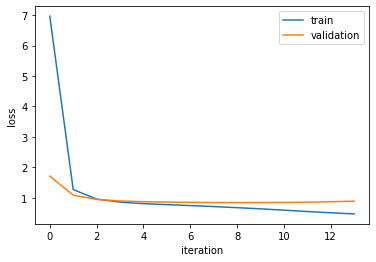

In [25]:
# plot training history
plt.plot(mf_opt_netflix.hist.history['loss'], label='train')
plt.plot(mf_opt_netflix.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

In [26]:
if use_pretrained_model_mf:
    mf_opt_netflix = MF(users_num=netflix_df.user_id.max()+1, items_num=netflix_df.item_id.max()+1, latent_dim=best_hps.get('latent_dim'), learning_rate=best_hps.get('learning_rate'))
    mf_opt_netflix.model = load_model('/content/proj/src/models/pretrained_models/Netflix/best_mf_model.h5')
else:
    mf_opt_netflix.model = load_model('best_mf_model.h5')

In [27]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [28]:
mf_opt_netflix.predict(test_netflix.user_id, test_netflix.item_id)

13/13 [==============================] - 0s 1ms/step


In [29]:
pred_df = test_netflix.copy()
pred_df.rating = mf_opt_netflix.predictions.reshape(-1)
pred_mat = df_to_mat(pred_df)
test_mat = df_to_mat(test_netflix)

### Evaluation

In [30]:
netflix_mf_opt_eval = Metrics.get_evaluation(test_mat, pred_mat)
netflix_mf_opt_eval

{'MRR_10': 0.9414763582582973,
 'MRR_5': 0.9414763582582973,
 'NDCG_10': 0.9625635410399038,
 'NDCG_100': 0.9543554843118671,
 'NDCG_5': 0.9668842178414259,
 'RMSE': 0.9155871375638455}

## IAutoRec

### Data Processing

In [31]:
# netflix_train_mat, netflix_test_mat = dataPreprocessor(netflix_df)
netflix_train_mat, netflix_test_mat = netflix_full_train_mat, netflix_full_test_mat

### Hyperparameters Tuning

In [32]:
netflix_autorec = IAutoRec(netflix_train_mat.shape[1])
tuner = kt.Hyperband(netflix_autorec.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                     factor=3,
                     directory='hyper_params',
                     project_name='autorec_netflix')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 4485)]            0         
                                                                 
 latent_dim (Dense)          (None, 300)               1345800   
                                                                 
 item_pred_rating (Dense)    (None, 4485)              1349985   
                                                                 
Total params: 2,695,785
Trainable params: 2,695,785
Non-trainable params: 0
_________________________________________________________________


In [33]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
tuner.search(netflix_train_mat, netflix_train_mat,
             epochs=500, validation_split=0.3, callbacks=[stop_early], batch_size=512)
# tuner.search(netflix_train_mat, netflix_train_mat,
#              epochs=500, validation_data=(netflix_full_val_mat,netflix_full_val_mat), callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 124 Complete [00h 00m 03s]
val_loss: 3.039339542388916

Best val_loss So Far: 1.06702721118927
Total elapsed time: 00h 06m 16s
INFO:tensorflow:Oracle triggered exit


In [34]:
best_hps.get('hidden_units'), best_hps.get('reg'), best_hps.get('learning_rate'), best_hps.get('first_activation'), best_hps.get('last_activation')

(900, 0.0001, 0.001, 'sigmoid', 'relu')

### Retraining

In [35]:
netflix_autorec_opt = IAutoRec(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), 
                               learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                               last_activation=best_hps.get('last_activation'))
netflix_autorec_opt.build_opt_model()
netflix_autorec_opt.fit(netflix_train_mat, netflix_train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 4485)]            0         
                                                                 
 latent_dim (Dense)          (None, 900)               4037400   
                                                                 
 item_pred_rating (Dense)    (None, 4485)              4040985   
                                                                 
Total params: 8,078,385
Trainable params: 8,078,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 - 1s - loss: 2.0028 - val_loss: 1.1289 - 1s/epoch - 19ms/step
Epoch 2/500
70/70 - 1s - loss: 1.0654 - val_loss: 1.0638 - 701ms/epoch - 10ms/step
Epoch 3/500
70/70 - 1s - loss: 1.0115 - val_loss: 1.0485 - 707ms/epoch - 10ms/step
Epoch 4/500
70/70 - 1s - loss: 0.9856 - val_loss: 1.0239 - 704ms/ep

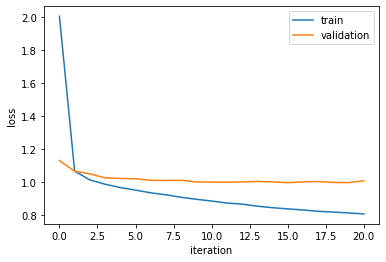

In [36]:
# plot training history
plt.plot(netflix_autorec_opt.hist.history['loss'], label='train')
plt.plot(netflix_autorec_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [37]:
if use_pretrained_model_autorec:
    netflix_autorec_opt = IAutoRec(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), reg=best_hps.get('reg'), 
                               learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                               last_activation=best_hps.get('last_activation'))    
    netflix_autorec_opt.model = load_model('/content/proj/src/models/pretrained_models/Netflix/best_autorec_model.h5')
else:
    netflix_autorec_opt.model = load_model('best_autorec_model.h5', custom_objects={'masked_rmse': IAutoRec.masked_rmse})

In [38]:
shutil.rmtree('/content/hyper_params')

### Prediction

In [39]:
netflix_autorec_opt.predict(netflix_test_mat)

39/39 [==============================] - 0s 5ms/step


### Evaluation

In [40]:
netflix_autorec_opt_eval = Metrics.get_evaluation(netflix_test_mat, netflix_autorec_opt.predictions)
netflix_autorec_opt_eval

{'MRR_10': 0.9534027143416417,
 'MRR_5': 0.9533918395754492,
 'NDCG_10': 0.9783502343761387,
 'NDCG_100': 0.9427604270869687,
 'NDCG_5': 0.9840546084262216,
 'RMSE': 0.8316370346480989}

in the paper, the authors reaches RMSE of 0.823, we got 0.832, but we need to remember that we used only a partial dataset due to RAM issues.

## IAutoRec Enhanced

### Hyperparameter Tuning

In [41]:
netflix_autorec_enhanced = IAutoRecEnhanced(netflix_train_mat.shape[1])
tuner = kt.Hyperband(netflix_autorec_enhanced.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced_netflix')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 4485)]            0         
                                                                 
 hidden_encoder_1 (Dense)    (None, 200)               897200    
                                                                 
 latent_dim (Dense)          (None, 100)               20100     
                                                                 
 hidden_decoder_1 (Dense)    (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 4485)              901485    
                                                                 
Total params: 1,838,985
Trainable params: 1,838,985
Non-trainable params: 0
_________________________________________________________________


In [42]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(netflix_train_mat, netflix_train_mat,
             epochs=500, validation_split=0.3, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 168 Complete [00h 00m 03s]
val_loss: 1.2197370529174805

Best val_loss So Far: 1.069174885749817
Total elapsed time: 00h 08m 47s
INFO:tensorflow:Oracle triggered exit


In [43]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('reg'), best_hps.get('learning_rate'), best_hps.get('first_activation'), best_hps.get('last_activation')

(100, 2, 0.0001, 0.001, 'elu', 'elu')

### Retraining

In [44]:
netflix_autorec_enhanced_opt = IAutoRecEnhanced(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                                hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                                learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                                last_activation=best_hps.get('last_activation'))
netflix_autorec_enhanced_opt.build_opt_model()
netflix_autorec_enhanced_opt.fit(netflix_train_mat, netflix_train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 4485)]            0         
                                                                 
 hidden_encoder (Dense)      (None, 200)               897200    
                                                                 
 latent_dim (Dense)          (None, 100)               20100     
                                                                 
 hidden_decoder (Dense)      (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 4485)              901485    
                                                                 
Total params: 1,838,985
Trainable params: 1,838,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
70/70 - 1s - loss: 1.5628 - val_loss:

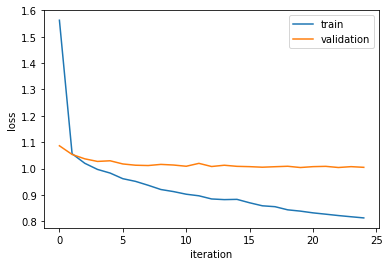

In [45]:
# plot training history
plt.plot(netflix_autorec_enhanced_opt.hist.history['loss'], label='train')
plt.plot(netflix_autorec_enhanced_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [46]:
if use_pretrained_model_autorec_enhanced:
    netflix_autorec_enhanced_opt = IAutoRecEnhanced(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                                    hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                                    learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                                    last_activation=best_hps.get('last_activation'))
    netflix_autorec_enhanced_opt.model = load_model('/content/proj/src/models/pretrained_models/Netflix/best_autorec_enhanced_model.h5')
else:
    netflix_autorec_enhanced_opt.model = load_model('best_autorec_enhanced_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced.masked_rmse})

### Prediction

In [47]:
netflix_autorec_enhanced_opt.predict(netflix_test_mat)

39/39 [==============================] - 0s 4ms/step


### Evaluation

In [48]:
netflix_autorec_enhanced_opt_eval = Metrics.get_evaluation(netflix_test_mat, netflix_autorec_enhanced_opt.predictions)
netflix_autorec_enhanced_opt_eval

{'MRR_10': 0.950455652703467,
 'MRR_5': 0.950455652703467,
 'NDCG_10': 0.9642134505380678,
 'NDCG_100': 0.9444972214791636,
 'NDCG_5': 0.9725268872538255,
 'RMSE': 0.9628700696934387}

our deep autoencoder architecture yeilds worse results, perhaps due to a needed heavy duty hyperparameter tuning.
we'll try a deeper network.

## IAutoRec Enhanced 2

### Hyperparameter Tuning

In [52]:
netflix_autorec_enhanced2 = IAutoRecEnhanced2(netflix_train_mat.shape[1])
tuner = kt.Hyperband(netflix_autorec_enhanced2.model_builder,
                     objective='val_loss',
                    #  objective='loss',
                     max_epochs=500,
                    #  factor=3,
                     directory='hyper_params',
                     project_name='autorec_enhanced2_netflix')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 4485)]            0         
                                                                 
 hidden_encoder_1 (Dense)    (None, 200)               897200    
                                                                 
 hidden_encoder_2 (Dense)    (None, 100)               20100     
                                                                 
 latent_dim (Dense)          (None, 50)                5050      
                                                                 
 hidden_decoder_1 (Dense)    (None, 100)               5100      
                                                                 
 hidden_decoder_2 (Dense)    (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 4485)              9014

In [53]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
tuner.search(netflix_train_mat, netflix_train_mat,
             epochs=500, validation_split=0.3, callbacks=[stop_early], batch_size=512)
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 127 Complete [00h 00m 02s]
val_loss: 2.868924140930176

Best val_loss So Far: 1.0754410028457642
Total elapsed time: 00h 07m 19s
INFO:tensorflow:Oracle triggered exit


In [54]:
best_hps.get('hidden_units'), best_hps.get('hidden_layer_factor'), best_hps.get('reg'), best_hps.get('learning_rate'), best_hps.get('first_activation'), best_hps.get('last_activation')

(50, 2, 0.0001, 0.001, 'elu', 'elu')

### Retraining

In [55]:
netflix_autorec_enhanced2_opt = IAutoRecEnhanced2(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                                hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                                learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                                last_activation=best_hps.get('last_activation'))
netflix_autorec_enhanced2_opt.build_opt_model()
netflix_autorec_enhanced2_opt.fit(netflix_train_mat, netflix_train_mat)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 item_rating (InputLayer)    [(None, 4485)]            0         
                                                                 
 hidden_encoder_1 (Dense)    (None, 200)               897200    
                                                                 
 hidden_encoder_2 (Dense)    (None, 100)               20100     
                                                                 
 latent_dim (Dense)          (None, 50)                5050      
                                                                 
 hidden_decoder_1 (Dense)    (None, 100)               5100      
                                                                 
 hidden_decoder_2 (Dense)    (None, 200)               20200     
                                                                 
 item_pred_rating (Dense)    (None, 4485)              9014

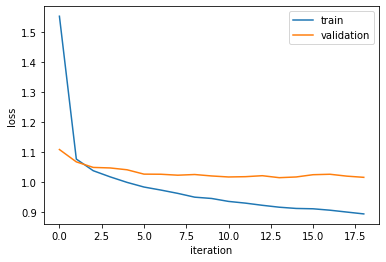

In [56]:
# plot training history
plt.plot(netflix_autorec_enhanced2_opt.hist.history['loss'], label='train')
plt.plot(netflix_autorec_enhanced2_opt.hist.history['val_loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()

In [58]:
if use_pretrained_model_autorec_enhanced2:
    netflix_autorec_enhanced2_opt = IAutoRecEnhanced2(netflix_train_mat.shape[1],hidden_units=best_hps.get('hidden_units'), 
                                                    hidden_layer_factor=best_hps.get('hidden_layer_factor'), reg=best_hps.get('reg'), 
                                                    learning_rate=best_hps.get('learning_rate'), first_activation=best_hps.get('first_activation'),
                                                    last_activation=best_hps.get('last_activation'))
    netflix_autorec_enhanced2_opt.model = load_model('/content/proj/src/models/pretrained_models/Netflix/best_autorec_enhanced2_model.h5')
else:
    netflix_autorec_enhanced2_opt.model = load_model('best_autorec_enhanced2_model.h5', custom_objects={'masked_rmse': IAutoRecEnhanced2.masked_rmse})

### Prediction

In [59]:
netflix_autorec_enhanced2_opt.predict(netflix_test_mat)

39/39 [==============================] - 0s 4ms/step


### Evaluation

In [60]:
netflix_autorec_enhanced2_opt_eval = Metrics.get_evaluation(netflix_test_mat, netflix_autorec_enhanced2_opt.predictions)
netflix_autorec_enhanced2_opt_eval

{'MRR_10': 0.9450976554004088,
 'MRR_5': 0.9450759058680238,
 'NDCG_10': 0.9589071395663803,
 'NDCG_100': 0.9389259890172728,
 'NDCG_5': 0.966259398428746,
 'RMSE': 1.0049403185121433}

the deeper model yeilds poorer results, as before, perhaps due to hyperparameter tuning

## Evaluation Summary

In [61]:
netflix_result_dict = {
    'mf': netflix_mf_opt_eval,
    'autorec': netflix_autorec_opt_eval,
    'autorec_enhanced': netflix_autorec_enhanced_opt_eval,
    'autorec_enhanced2': netflix_autorec_enhanced2_opt_eval,
               }
netflix_res_df = pd.DataFrame.from_dict(netflix_result_dict)
netflix_res_df

,mf,autorec,autorec_enhanced,autorec_enhanced2
RMSE,0.915587,0.831637,0.962870,1.004940
MRR_5,0.941476,0.953392,0.950456,0.945076
MRR_10,0.941476,0.953403,0.950456,0.945098
NDCG_5,0.966884,0.984055,0.972527,0.966259
NDCG_10,0.962564,0.978350,0.964213,0.958907
NDCG_100,0.954355,0.942760,0.944497,0.938926


Text(0.5, 1.0, 'netflix prize models results')

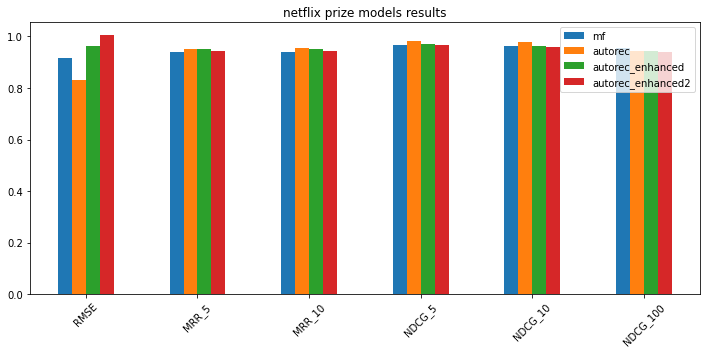

In [62]:
netflix_res_df.plot(kind='bar', figsize=(12,5), rot=45)
plt.title('netflix prize models results')

Text(0.5, 1.0, 'netflix prize models results')

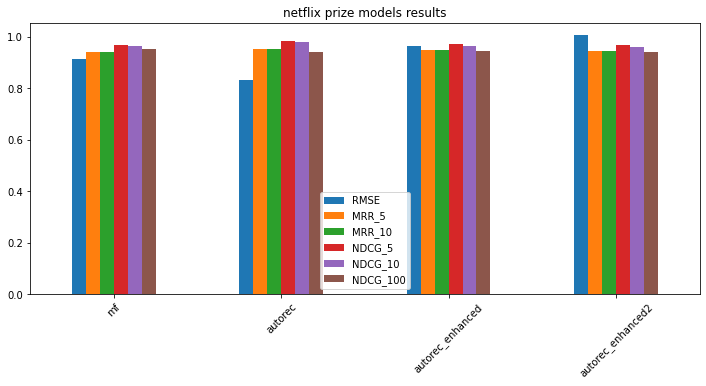

In [63]:
netflix_res_df.transpose().plot(kind='bar', figsize=(12,5), rot=45)
plt.title('netflix prize models results')